In [10]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [2]:
import pyodbc
def connect_to_db():
    """
    Tengist VHG með pyodbc pakkanum
    """
    sql_conn = pyodbc.connect("""DRIVER={SQL Server};
                                 SERVER=VHG;
                                 DATABASE=Kerfiradur_mirror;
                                 Trusted_Connection=yes""")
    return sql_conn
def execute_query(conn, sql):
    return pd.read_sql(sql, conn, parse_dates=['ctime','date_time','value_dates'])


In [3]:
conn = connect_to_db()

In [4]:
query = f'''
SELECT [dags]
      ,[rennsli]
      ,[rennsli_virkjanasvaedi]
      ,[rennsli_laghitasvaedi]
  FROM [DM_Veitur].[hitaveita].[heitavatnsspa_framrennsli_400d]
  where obs_forecast = 'o'
  order by dags desc
'''
df_rennsli = execute_query(conn,query)

In [5]:
query = f'''
select * 
FROM [DM_Orkuveitan].[dbo].[fact_vedurgogn]
where date_time > '2019-09-09' and station_id = 1475
    '''
df_hitastig = execute_query(conn,query)


In [6]:
df_H = df_hitastig.pivot_table(columns='station_id',values='temperature',index = 'date_time')
df_H = pd.DataFrame(df_H.loc[:,1475])
df_H.index = pd.to_datetime(df_H.index)

In [7]:
df_rennsli.index = pd.to_datetime(df_rennsli.dags)
df_R = df_rennsli.loc[:,['rennsli']]


In [11]:
df = pd.concat([df_H.loc[:,1475],df_R.loc[:,'rennsli']],axis=1)
df = df.dropna().resample('1h').mean().interpolate()

ohe = OneHotEncoder()
ohe_ToD = ohe.fit_transform(df.index.hour.values.reshape(-1,1))
ohe_WW = ohe.fit_transform(df.index.weekday.values.reshape(-1,1) >= 5)
ohe_MoY = ohe.fit_transform(df.index.month.values.reshape(-1,1))
ohe_ToD = ohe_ToD.toarray()
ohe_WW = ohe_WW.toarray()

x,y = df.values.T


In [12]:
ohe_WW.shape,ohe_ToD.shape

((19192, 2), (19192, 24))

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import r2_score

p = 168*2
x_win = np.lib.stride_tricks.sliding_window_view(x,window_shape=p)
y_win = np.lib.stride_tricks.sliding_window_view(y,window_shape=p)[:,-1]
ohe_ToD_win = np.lib.stride_tricks.sliding_window_view(ohe_ToD,window_shape=(p,24)).squeeze()[:,-1]
ohe_DoW_win = np.lib.stride_tricks.sliding_window_view(ohe_WW,window_shape=(p,2)).squeeze()[:,-1]

print(x_win.shape,ohe_ToD_win.shape)
# x_combined = np.c_[x_win,ohe_ToD_win,ohe_DoW_win]
# x_combined = np.c_[x_win,ohe_ToD_win]
x_combined = x_win#np.c_[]

n = len(x_win)
idx = np.arange(n)
train = idx[:n//2]
test = idx[n//2:]

Y_train = y_win[train]
Y_test = y_win[test]


X_train = x_combined[train]
X_test = x_combined[test]


reg = Ridge()
# reg = Lasso(1000)
reg.fit(X_train,Y_train)
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)


MSE_train = np.mean((Y_train-Y_train_pred)**2)
MSE_test = np.mean((Y_test-Y_test_pred)**2)

MAE_train = np.mean(np.abs(Y_train-Y_train_pred))
MAE_test = np.mean(np.abs(Y_test-Y_test_pred))

corr_train = np.corrcoef(Y_train,Y_train_pred)[0,1]
corr_test = np.corrcoef(Y_test,Y_test_pred)[0,1]
    
r2_train = r2_score(Y_train,Y_train_pred)
r2_test = r2_score(Y_test,Y_test_pred)
    
print(MSE_train,MSE_test)
print(MAE_train,MAE_test)
print(corr_train,corr_test)
print(r2_train,r2_test)
# rolling 1 1231756.196597714
# rolling 24 800393.4551481506
# rolling 48 745571.8939299225.4551481506
# rolling 168 745571.8939299225.4551481506

(18857, 336) (18857, 24)
587113.7155770089 1240763.2684483347
530.6881548199215 857.8817726569107
0.9720636671853892 0.9439066625550814
0.9449077730617129 0.8769667215206072


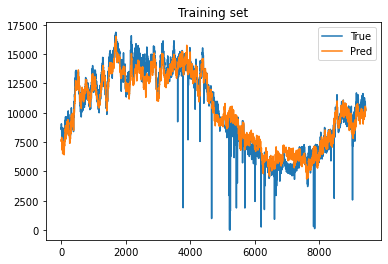

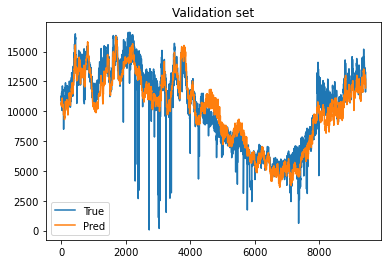

In [145]:

plt.plot(Y_train)
plt.plot(Y_train_pred)
plt.title('Training set')
plt.legend(['True','Pred'])
plt.show()

plt.plot(Y_test)
plt.plot(Y_test_pred)
plt.title('Validation set')
plt.legend(['True','Pred'])
plt.show()



(-0.9450413690559402, 55)

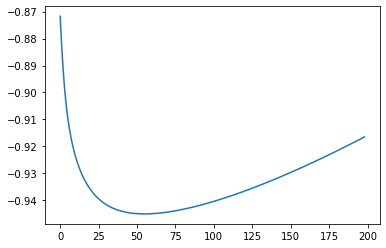

In [16]:
corr_vals = []
for i in range(1,200):
    corr_val = df.iloc[:,0].ewm(halflife=i).mean().corr(df.iloc[:,1])
    # corr_val = df.iloc[:,0].rolling(i).mean().corr(df.iloc[:,1])
    corr_vals.append(corr_val)
plt.plot(corr_vals)
np.min(corr_vals),np.argmin(corr_vals)

In [68]:
df.iloc[:,0].rolling(1).mean().corr(df.iloc[:,1]),df.iloc[:,0].rolling(168).mean().corr(df.iloc[:,1]),df.iloc[:,0].ewm(halflife=25).mean().corr(df.iloc[:,1])

(-0.8627306423943666, -0.9255371213430015, -0.9387787816708361)

Text(0.5, 1.0, 'District heating outside\ntemperature relationship (2019-2021)')

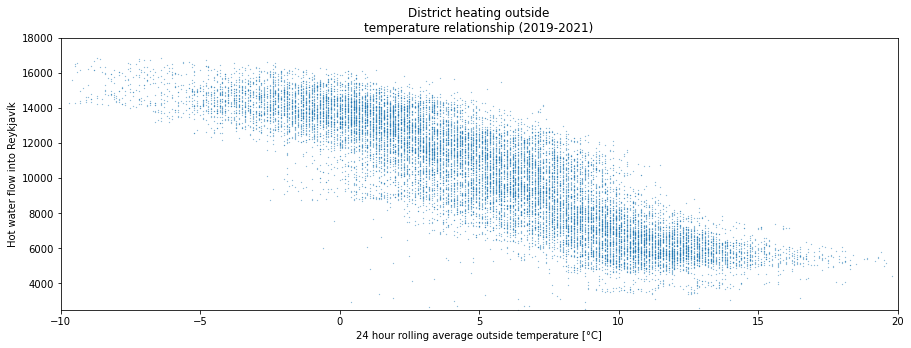

In [69]:

plt.figure(figsize=(15,5))
plt.scatter(df.iloc[:,0].rolling(1).mean(),df.iloc[:,1],s = 0.04)
plt.xlim(-10,20)
plt.ylim(2500,18000)
plt.xlabel('24 hour rolling average outside temperature [°C]')
plt.ylabel('Hot water flow into Reykjavík')
plt.title('District heating outside\ntemperature relationship (2019-2021)')

Text(0.5, 1.0, 'District heating outside\ntemperature relationship (2019-2021)')

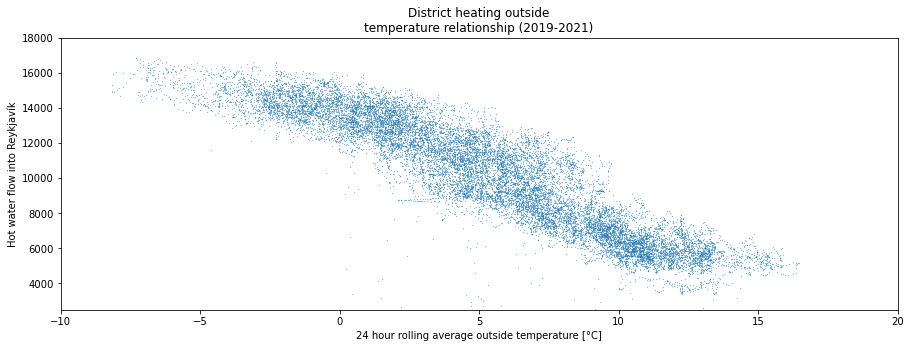

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.scatter(df.iloc[:,0].rolling(24).mean(),df.iloc[:,1],s = 0.04)
plt.xlim(-10,20)
plt.ylim(2500,18000)
plt.xlabel('24 hour rolling average outside temperature [°C]')
plt.ylabel('Hot water flow into Reykjavík')
plt.title('District heating outside\ntemperature relationship (2019-2021)')

Text(0.5, 1.0, 'District heating outside\ntemperature relationship (2019-2021)')

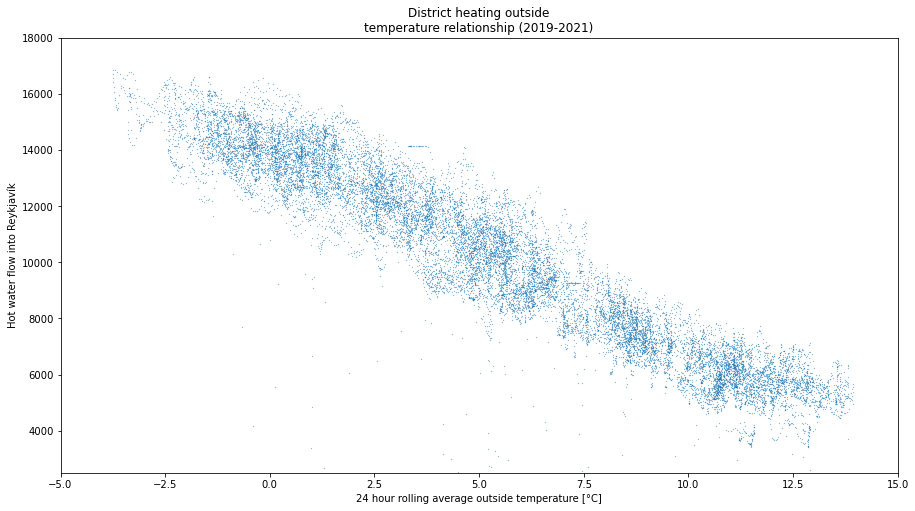

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.scatter(df.iloc[:,0].ewm(halflife=55).mean(),df.iloc[:,1],s = 0.04)
# plt.scatter(df.iloc[:,0].rolling(24).mean(),df.iloc[:,1],s = 0.04)
# plt.xlim(-10,20)
plt.xlim(-5,15)
plt.ylim(2500,18000)
plt.xlabel('24 hour rolling average outside temperature [°C]')
plt.ylabel('Hot water flow into Reykjavík')
plt.title('District heating outside\ntemperature relationship (2019-2021)')